# Capstone 3: *Cancer Gene Expression Classification*
## *Expanded Modeling*
***

## 3.1 Table of Contents<a id='3.1_Contents'></a>
* [3 Preprocessing, Training, and Modeling](#3_Data_wrangling)
  * [3.1 Table of Contents](#3.1_Contents)
  * [3.2 Introduction](#3.2_Introduction)
  * [3.3 Importing the Dependencies](#3.3_Importing_the_Dependencies)
  * [3.4 Importing the Data](#3.4_Importing_the_Data)
  * [3.5 Baseline Model](#3.5_Baseline_Model)
  * [3.6 Additional Models](#3.6_Additional_Models)
      * [3.6.1 Linear Models](#3.6.1_Linear_Models)
      * [3.6.2 Non-linear Models](#3.6.2_Non-linear_Models)
  * [3.7 Selecting the Best Model](#3.7_Selecting_the_Best_Model)
  * [3.8 Interpretation with SHAP](#3.8_Interpretation_with_SHAP)
      * [3.8.1 Class 0: BRCA (breast)](#3.8.1_Class_0)
      * [3.8.2 Class 1: COAD (colon)](#3.8.2_Class_1)
      * [3.8.3 Class 2:  KIRC (kidney)](#3.8.3_Class_2)
      * [3.8.4 Class 3:  LUAD (lung)](#3.8.3_Class_3)
      * [3.8.5 Class 4:  PRAD (prostate)](#3.8.3_Class_4)
  * [3.9 Summary](#Summary)
 

## 3.2 Introduction
<a id='3.2_Introduction'></a>
The baseline model is complete and shows excellent results with the training data.  In this notebook, I will show the baseline model's prediction ability with the test data.  I will then explore additional models - both linear and non linear - and select the best one.  Finally, I will use SHAP for interpreting the results assiciated with the chosen model.

## 3.3 Importing the Dependencies
<a id='3.3_Importing_the_Dependencies'></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap 
import xgboost as xgb


from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier

#pd.set_option('display.max_rows', 70)

## 3.4 Importing the Data
<a id='3.4_Importing_the_Data'></a>

In [2]:
data = pd.read_csv("../source_data/data.csv")
labels = pd.read_csv("../source_data/labels.csv")

In [3]:
X = pd.read_csv("X.csv")
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")

In [4]:
#y = np.loadtxt('y.txt')
#y_train = np.loadtxt('y_train.txt')
#y_test = np.loadtxt('y_test.txt')

y = pd.read_csv("y.csv")
y_train = pd.read_csv("y_train.csv")
y_test = pd.read_csv("y_test.csv")

## 3.5 Baseline Model
<a id='3.5_Baseline_Model'></a>

In [5]:
steps = [('pca', PCA(n_components=7)),
         ('clf', LogisticRegression(max_iter = 5000, multi_class='auto'))]
pipe_lr = Pipeline(steps)

pipe_lr.fit(X_train, y_train.values.ravel())
          
lr_y_pred_test = pipe_lr.predict(X_test)
#y_pred_train_lr = pipe_lr.predict(X_train)

best_lr_f1 = f1_score(y_test, lr_y_pred_test, average='macro')

print("Test set f1_macro score for baseline model:", best_lr_f1)


Test set f1_macro score for baseline model: 0.994710743801653


## 3.6 Additional Models
<a id='3.6_Additional_Models'></a>
The baseline model performs very well, but I will try some other models, both linear and non-linear, and compare performance.

### 3.6.1 Linear Models
<a id='3.6.1_Linear_Models'></a>

In [6]:
# Editing function for single linear model

def execute_linear_model (name, model):
    
    # get the  mean f1 macro averaged score across five folds using StratifyKFold
    # save y_test_pred for later use

    # execute model from list of models
    steps = [('pca', PCA(n_components=7)),
             ('clf', model)]
    pipe = Pipeline(steps)
    k = 5
    cv = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
    
    # get the f1 macro averaged score for each fold and then find the mean
    single_scores_train = cross_val_score(pipe, X_train, y_train.values.ravel(), scoring='f1_macro', cv=cv)
    mean_score_train = np.mean(single_scores_train).round(5)
        
    #scores_test = pipe(X_test, y_test.values.ravel(), scoring='f1_macro')
    pipe.fit(X_train, y_train.values.ravel())
    y_test_pred = pipe.predict(X_test)
    score_test = f1_score(y_test, y_test_pred, average='macro')        
    
    return mean_score_train, score_test, y_test_pred



In [7]:
def get_classification_report (model, y_pred):
    # get the classification report from a given model's y_pred value
    
    print(model, "classification report:\n", classification_report(y_test, y_pred))
    return


In [8]:
def get_confusion_matrix_plot (model, y_pred):
    # Create confusion matrix for given model
    multilabel_confusion_matrix = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    fig, ax = plt.subplots(1,1,figsize=(6,4))
    #fig.suptitle(("Confusion Matrix for", model), fontsize=20, y=1.0)

    sns.heatmap(multilabel_confusion_matrix, cmap='crest', annot=True, ax=ax)
    ax.set_title(f"Confusion Matrix for {model}", fontsize=15)
    ax.set(ylabel="True", xlabel="Predicted");
    return



**Naive Bayes**

In [9]:
# get the scores for training and test data
# get the y_pred values for the test set for later use

nb_mean_score_train, best_nb_f1, nb_y_test_pred = execute_linear_model ('Naive Bayes', GaussianNB())
print("Mean train score for Naive Bayes:", nb_mean_score_train)
print("Test score for Naive Bayes:", best_nb_f1)

Mean train score for Naive Bayes: 0.98907
Test score for Naive Bayes: 0.9847526373919336


In [10]:
get_classification_report('Naive Bayes', nb_y_test_pred)

Naive Bayes classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       1.00      0.94      0.97        16
           2       1.00      1.00      1.00        30
           3       0.96      0.96      0.96        28
           4       1.00      1.00      1.00        27

    accuracy                           0.99       161
   macro avg       0.99      0.98      0.98       161
weighted avg       0.99      0.99      0.99       161



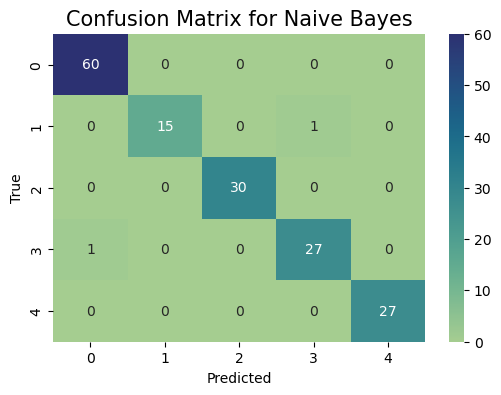

In [11]:
get_confusion_matrix_plot ('Naive Bayes', nb_y_test_pred)

**Support Vector Classifier**

In [12]:
# get the scores for training and test data
# get the y_pred values for the test set for later use

svc_mean_score_train, best_svc_f1, svc_y_test_pred = execute_linear_model ('Support Vector Classifier', SVC(max_iter = 5000, random_state=42))
print("Mean train score for Support Vector Classifier:",svc_mean_score_train)
print("Test score for Support Vector Classifier:", best_svc_f1)

Mean train score for Support Vector Classifier: 0.99597
Test score for Support Vector Classifier: 0.994710743801653


In [13]:
get_classification_report('Support Vector Classifier', svc_y_test_pred)

Support Vector Classifier classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        30
           3       1.00      0.96      0.98        28
           4       1.00      1.00      1.00        27

    accuracy                           0.99       161
   macro avg       1.00      0.99      0.99       161
weighted avg       0.99      0.99      0.99       161



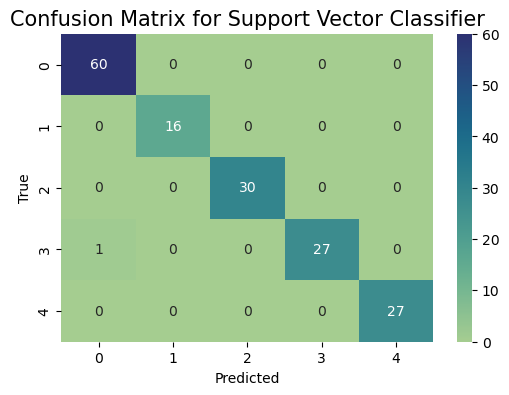

In [14]:
get_confusion_matrix_plot ('Support Vector Classifier', svc_y_test_pred)

### 3.6.2 Non-linear Models
<a id='3.6.2_Non-linear_Models'></a>

In [15]:
def run_model_with_best_params (model, best_params):
    #run a model with its best parameters
    #find the f1 macro score for the test set

    model = model
    model.set_params(**best_params)

    steps = [('pca', PCA(n_components=7)),
             ('clf', model)]
    pipe = Pipeline(steps)
    
    pipe.fit(X_train, y_train.values.ravel())
          
    y_pred_test = pipe.predict(X_test)
    score = f1_score(y_test, y_pred_test, average='macro')
    return score, y_pred_test


   **Random Forest**

In [16]:
# working code - rf param search using loops 09 May 23

pca = PCA(n_components=7)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

def single_rf (n_estimators, max_features, max_depth, min_samples_leaf, min_samples_split, criterion):
    # run a single rf model given parameters and return the oob_error
    clf_rf = RandomForestClassifier(random_state=42, oob_score=True, bootstrap=True, 
                                    max_samples=0.8, warm_start=True, 
                                    n_estimators=n_estimators, max_features=max_features, 
                                    max_depth=max_depth, min_samples_leaf=min_samples_leaf, 
                                    min_samples_split=min_samples_split, criterion=criterion)
    clf_rf.fit(X_train_pca, y_train.values.ravel())

    # Obtain the OOB error
    oob_error = 1 - clf_rf.oob_score_
    return oob_error
  
#n_estimators = [100, 500, 1000, 2000, 3000, 4000, 5000]
#max_features = ['log2', 'sqrt']
#max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
#min_samples_leaf = [1, 2, 4]
#min_samples_split = [2, 5, 10]
#criterion = ['gini', 'entropy', 'log_loss']

n_estimators = [100, 500, 1000, 2000]
max_features = ['log2', 'sqrt']
max_depth = [10, 20, None]
min_samples_leaf = [1, 2, 4]
min_samples_split = [2, 5, 10]
criterion = ['gini', 'entropy', 'log_loss']

error = 100
params_rf = []

for a in n_estimators:
    for b in max_features:
        for c in max_depth:
            for d in min_samples_leaf:
                for e in min_samples_split:
                    for f in criterion:
                        oob_e = single_rf(a, b, c, d, e, f)
                        if oob_e<error:
                            error = oob_e
                            params_rf.clear()
                            params_rf.append(a)
                            params_rf.append(b)
                            params_rf.append(c)
                            params_rf.append(d)
                            params_rf.append(e)
                            params_rf.append(f)
                        else:
                            continue    


param_names_rf = ['n_estimators','max_features','max_depth','min_samples_leaf','min_samples_split','criterion']
best_params_rf = dict(zip(param_names_rf, params_rf))
print('Best rf params:', best_params_rf)
print('\nOOB Error:', error)


Best rf params: {'n_estimators': 1000, 'max_features': 'log2', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'criterion': 'entropy'}

OOB Error: 0.0015625000000000222


In [17]:
print("RandomForestClassifier f1 score with best params:")
best_rf_f1, rf_y_pred_test = run_model_with_best_params(RandomForestClassifier(random_state=42, oob_score=True, bootstrap=True, 
                                    max_samples=0.8, warm_start=True), best_params_rf)
print(best_rf_f1)

RandomForestClassifier f1 score with best params:
0.9793606076630932


In [18]:
get_classification_report('Random Forest', rf_y_pred_test)

Random Forest classification report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        60
           1       1.00      0.94      0.97        16
           2       1.00      1.00      1.00        30
           3       0.96      0.93      0.95        28
           4       1.00      1.00      1.00        27

    accuracy                           0.98       161
   macro avg       0.99      0.97      0.98       161
weighted avg       0.98      0.98      0.98       161



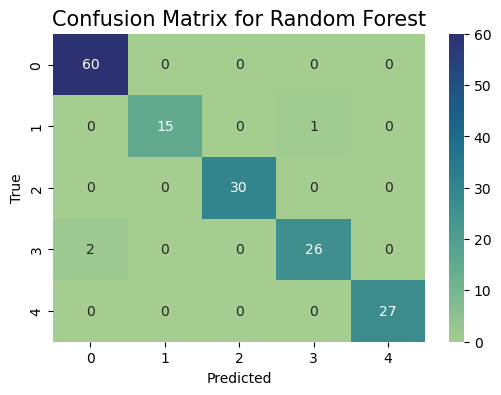

In [19]:
get_confusion_matrix_plot('Random Forest', rf_y_pred_test)

**XGBoost**

In [20]:
# Parameter tuning in three phases for increased speed

pca = PCA(n_components=7)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

def single_xgb (max_depth, min_child_weight, subsample, colsample_bytree, gamma, learning_rate):
    # run a single xgb model given parameters and return the error

    clf=XGBClassifier(max_depth=max_depth, 
                      min_child_weight=min_child_weight,
                      subsample=subsample, 
                      colsample_bytree=colsample_bytree, 
                      gamma=gamma,
                      learning_rate=learning_rate,  
                      early_stopping_rounds=10, 
                      eval_metric='merror')
    eval_set = [(X_test, y_test)]
    clf.fit(X_train, y_train.values.ravel(), eval_set=eval_set, verbose=False)

    y_pred = clf.predict(X_test)
    
    # Obtain accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# tuning max_depth and min_child_weight with other parameters set to default values

max_depth = [3,4,5,6]
min_child_weight = [0,1,2,3,4,5,6,7,8,9]

accuracy = 0
params_xgb = []

max_d = 0
min_cw = 0

for a in max_depth:
    for b in min_child_weight:
        acc = single_xgb(a, b, 1, 1, 0, 0.3)
        
        if acc>accuracy:                            
            accuracy = acc
            max_d = a
            min_cw = b
            
        else:
            continue

# tuning subsample and colsample_bytree
# values for max_depth and min_child_weight set to best params from above
# other params set to default values

subsample = [0.5, 1.0, 0.1]
colsample_bytree = [0.1, 0.5, 1]

accuracy = 0
subsamp = 0
colsamp = 0

for c in subsample:
    for d in colsample_bytree:
        acc = single_xgb(max_d, min_cw, c, d, 0, 0.3)
        
        if acc>accuracy:                            
            accuracy = acc
            subsamp = c
            colsamp = d
            
        else:
            continue
                

# tuning learning_rate and gamma
# values for max_depth, min_child_weight, subsample,  and colsample_bytree set to best params from above

learning_rate = [0.1, 0.2, 0.3, 0.4]
gamma = [1,2,3, 4, 5, 6, 8, 10, 12, 14, 16, 18, 20]
                
accuracy = 0
learn_r = 0
gam = 0


for e in gamma:
    for f in learning_rate:
        acc = single_xgb(max_d, min_cw, subsamp, colsamp, e, f)
        
        if acc>accuracy:                            
            accuracy = acc
            learn_r = e
            gam = f
            
        else:
            continue

                
max_depth = max_d
min_child_weight = min_cw
subsample = subsamp
colsample_bytree = colsamp
learning_rate = learn_r
gamma = gam

params_xgb.clear()
params_xgb.append(max_depth)
params_xgb.append(min_child_weight)
params_xgb.append(subsample)
params_xgb.append(colsample_bytree)
params_xgb.append(learning_rate)
params_xgb.append(gamma)    


# print best params and accuracy
param_names_xgb = ['max_depth','learning_rate','subsample','gamma','colsample_bytree','min_child_weight']
best_params_xgb = dict(zip(param_names_xgb, params_xgb))
print('Best xgb params:', best_params_xgb)
print('\nAccuracy:', accuracy)



Best xgb params: {'max_depth': 3, 'learning_rate': 9, 'subsample': 0.5, 'gamma': 0.1, 'colsample_bytree': 1, 'min_child_weight': 0.3}

Accuracy: 0.9937888198757764


In [21]:
def single_xgb_f1_score (params):
    # run a single xgb model given parameters and return the f1 macro score

    clf=XGBClassifier(params, early_stopping_rounds=10, 
                      eval_metric='merror')
    eval_set = [(X_test, y_test)]
    clf.fit(X_train, y_train.values.ravel(), eval_set=eval_set, verbose=False)

    y_pred_test = clf.predict(X_test)
    

    f1 = f1_score(y_test, y_pred_test, average='macro')
    return f1, y_pred_test

print("XGBClassifier f1 score with best params:")
best_xgb_f1, xgb_y_pred_test = single_xgb_f1_score(best_params_xgb)
print(best_xgb_f1)

XGBClassifier f1 score with best params:


Pass `objective` as keyword args.


0.9812603897742624


In [22]:
get_classification_report('XGBClassifier', xgb_y_pred_test)

XGBClassifier classification report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98        60
           1       1.00      0.94      0.97        16
           2       1.00      1.00      1.00        30
           3       1.00      0.96      0.98        28
           4       1.00      0.96      0.98        27

    accuracy                           0.98       161
   macro avg       0.99      0.97      0.98       161
weighted avg       0.98      0.98      0.98       161



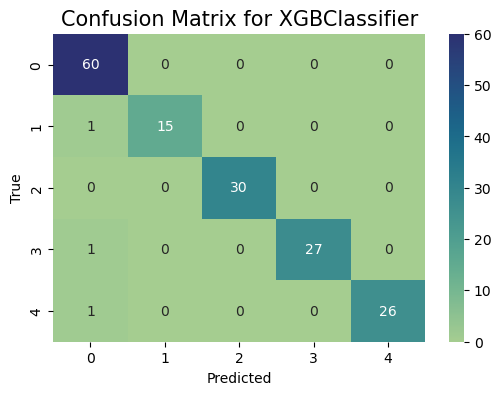

In [23]:
get_confusion_matrix_plot('XGBClassifier', xgb_y_pred_test)

**KNeighborsClassifier**

In [24]:
# knc with randomized search and cross validation
### research scorer_

pca = PCA(n_components=7)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

param_grid_knc = [{ 
    'n_neighbors': list(range(1,10)),
    'weights': ['uniform','distance'],
    'leaf_size': list(range(2,30)),
    'p': [1,2]
}]

def tune_model (clf, param_grid, score_method):
    # Use randomized search to find best parameters for a model
    
    CV = RandomizedSearchCV(clf, param_grid, scoring = score_method, 
                            n_iter=10, cv=5, n_jobs= 1)
    CV.fit(X_train, y_train.values.ravel())
    
    best_score = CV.best_score_
    best_params = CV.best_params_
    
    return best_score, best_params

best_score_knc, best_params_knc = tune_model(KNeighborsClassifier(), param_grid_knc, 'f1_macro')
### should scoring method be f1_macro here or accuracy?

print('\nBest parameter combination knc:', best_params_knc)
print('Best score knc:', best_score_knc)




Best parameter combination knc: {'weights': 'distance', 'p': 2, 'n_neighbors': 5, 'leaf_size': 20}
Best score knc: 1.0


In [25]:
print("KNeighborsClassifier f1 score with best params:")
best_knc_f1, knc_y_pred_test = run_model_with_best_params(KNeighborsClassifier(), best_params_knc)
print(best_knc_f1)

KNeighborsClassifier f1 score with best params:
0.994710743801653


In [26]:
get_classification_report('KNeighborsClassifier', knc_y_pred_test)

KNeighborsClassifier classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        30
           3       1.00      0.96      0.98        28
           4       1.00      1.00      1.00        27

    accuracy                           0.99       161
   macro avg       1.00      0.99      0.99       161
weighted avg       0.99      0.99      0.99       161



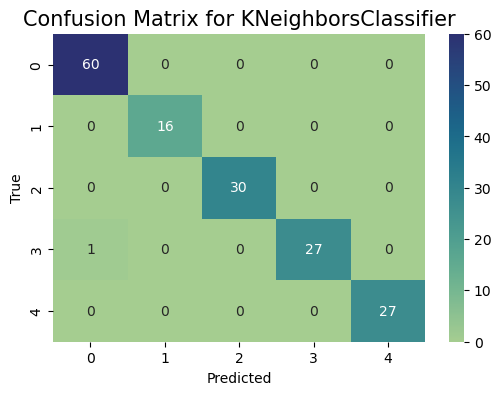

In [27]:
get_confusion_matrix_plot('KNeighborsClassifier', knc_y_pred_test)

## 3.7 Selecting the Best Model
<a id='3.7_Selecting_the_Best_Model'></a>

In [28]:
model_names = ['Logistic Regression','Support Vector Classifier','Naive Bayes','KNeighborsClassifier','Random Forest','XGBoostClassifier']
model_f1s = [best_lr_f1, best_svc_f1, best_nb_f1, best_knc_f1, best_rf_f1, best_xgb_f1]
model_f1s_df = pd.DataFrame(
    {'model names': model_names,
     'f1 scores': model_f1s
    })
model_f1s_df = model_f1s_df.sort_values(by=['f1 scores','model names'], ascending=[False, True])
model_f1s_df

model names  f1 scores
3       KNeighborsClassifier   0.994711
0        Logistic Regression   0.994711
1  Support Vector Classifier   0.994711
2                Naive Bayes   0.984753
5          XGBoostClassifier   0.981260
4              Random Forest   0.979361

All six of the models perform well but three tie for the highest f1 macro score: KNeighborsClassifier, Logistic Regression, and Support Vector Classifier.  Any of the three would be a good choice when predicting the cancer type of new samples of gene expression data.

## 3.8 Interpretation with SHAP
<a id='3.8_Interpretation_with_SHAP'></a>
For interpretation, I will use the highest performing tree based model: XGBoostClassifier.  A tree based model will allow me to use SHAP's TreeExplainer which is both more efficient, more exacting, and faster to run than SHAPs KernalExplainer.  (References: https://edden-gerber.github.io/shapley-part-1/ and https://christophm.github.io/interpretable-ml-book/shap.html) The f1 macro score for the XGBoostClassifer model was only 0.013451 lower than the highest performing models, so I believe it is worth using the tree based model to gain the extra accuracy in interpretation.  

I will utilize all samples and all features when I implement SHAP so we can gain the most knowledge about which genes are of greatest importance to the identification of each cancer type.


In [29]:
Model_xgbc_all = xgb.XGBClassifier(best_params_xgb)

Pass `objective` as keyword args.


In [30]:
Model_xgbc_all.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

In [31]:
shap.initjs()
explainer = shap.TreeExplainer(Model_xgbc_all)
shap_values = explainer.shap_values(X)
shap_obj = explainer(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


I'll start by looking at the SHAP summary plot to find the 20 most important features.

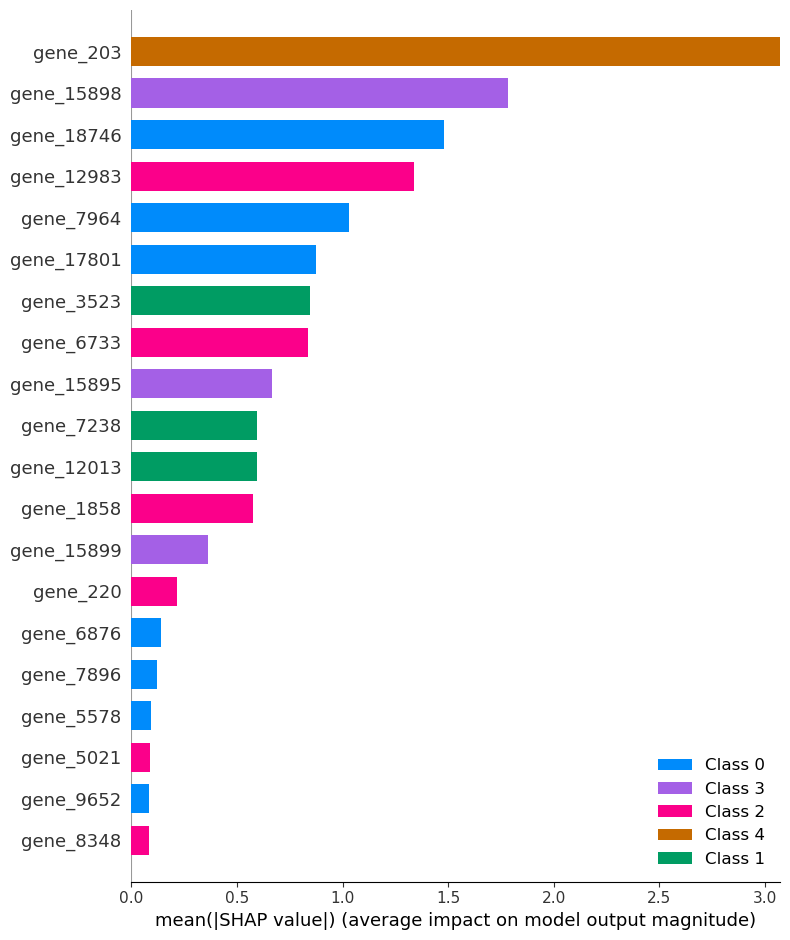

In [32]:
shap.summary_plot(shap_values, X, plot_type="bar")

This is a very interesting result.  Each of the top 20 most important features maps its to exactly one class, meaning none of these genes are important to more than one class.  This high degree of difference in feature importance helps us understand why the f1 macro scores for all of the models were so high - the classes are quite easy to separate.

One additional observation: the feature with the highest feature importance, gene_203 maps to class 4 which is prostate cancer.  This is the only one of the top 20 features for class 4.  I'll look at feature importance for each class separately to see what else I can learn.

### 3.8.1 Class 0: BRCA (breast)
<a id='3.8.1_Class_0'></a>


In [33]:
a = ['0: BRCA (breast)','1: COAD (colon)','2: KIRC (kidney)','3: LUAD (lung)','4: PRAD (prostate)']

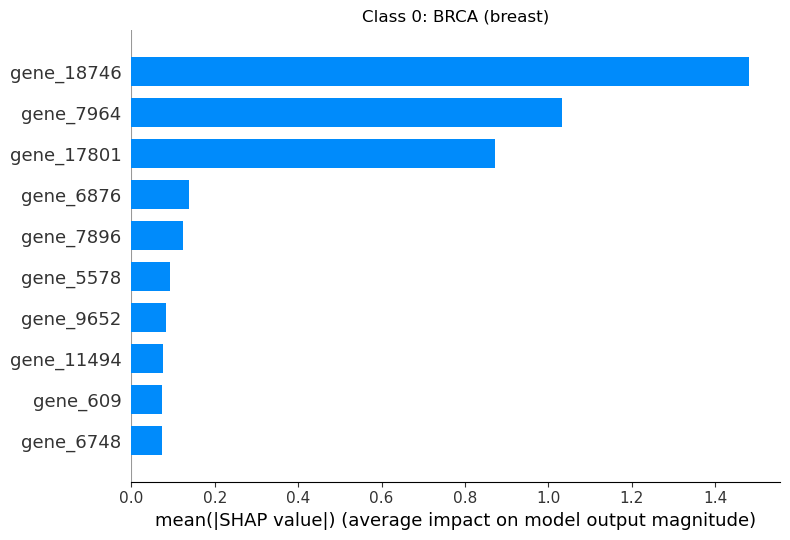

In [34]:
def get_summary_bar_plot (class_num):
    message = f"Class {a[class_num]}"
    plt.title(message)
    return shap.summary_plot(shap_values[class_num], X, plot_type="bar", max_display=10)
    
get_summary_bar_plot(0)

From the feature importance plot above, we can see that genes 18746, 7964, and 17801 are the most important for determininging members of this class.  This plot given us the magnitude of importance but it does not give us the direction (positive or negative).

Let's examine a single prediction using a waterfall plot so we can see how (and in which direction) these features are influencing the prediction of the class.

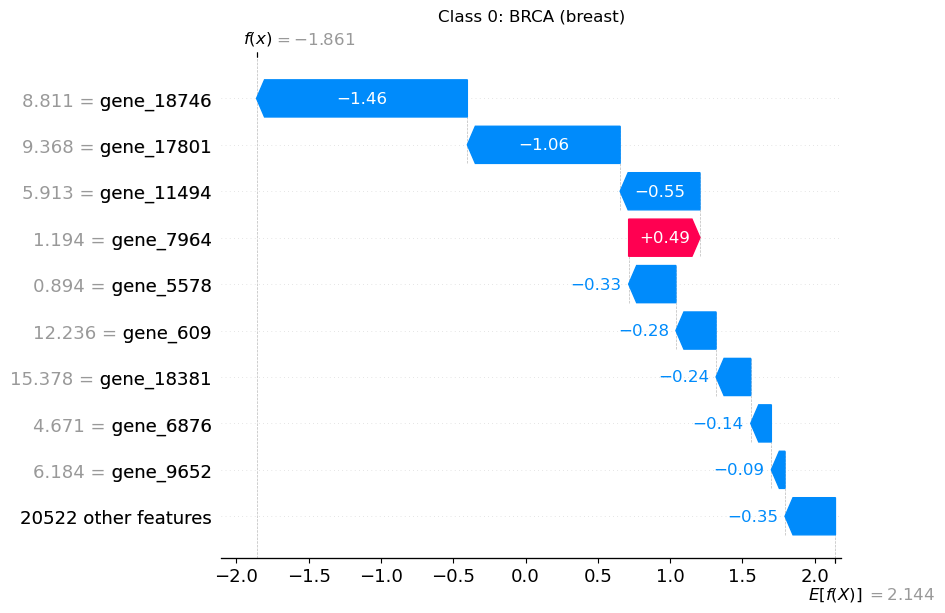

In [35]:
def get_waterfall_plot (class_num, row):
    message = f"Class {a[class_num]}"
    plt.title(message)
    return shap.waterfall_plot(shap.Explanation(values=shap_values[class_num][row], 
                                         base_values=explainer.expected_value[class_num], 
                                         data=X.iloc[row],  
                                         feature_names=X.columns.tolist()))
    
get_waterfall_plot(0,5)

The waterfall plot above shows that for this particular prediction, the value of gene_18746 (8.811) lowered the likelihood of this being classified as breast cancer.  Whereas in the force plot below, also representing a single prediction, the higher value of gene_18746 (14.44) increases the liklihood of this being classified as breast cancer.

In [36]:
def get_force_plot (class_num, row):
    shap.initjs()
    print("Contributing Features for Single Model Prediction in Class", a[class_num])
    return shap.force_plot(explainer.expected_value[class_num], shap_values[class_num][row], X.values[row], feature_names = X.columns)
    
get_force_plot (0,4)

Contributing Features for Single Model Prediction in Class 0: BRCA (breast)


Examining the summary plot below reinforces the idea that higher SHAP values for gene_18746 lead make it more likely to be classified as breast cancer, and lower SHAP values of gene_18746 make it less likely.  However, the lower end is a a little muddy.  We'll see what the swarm plot can tell us about this.

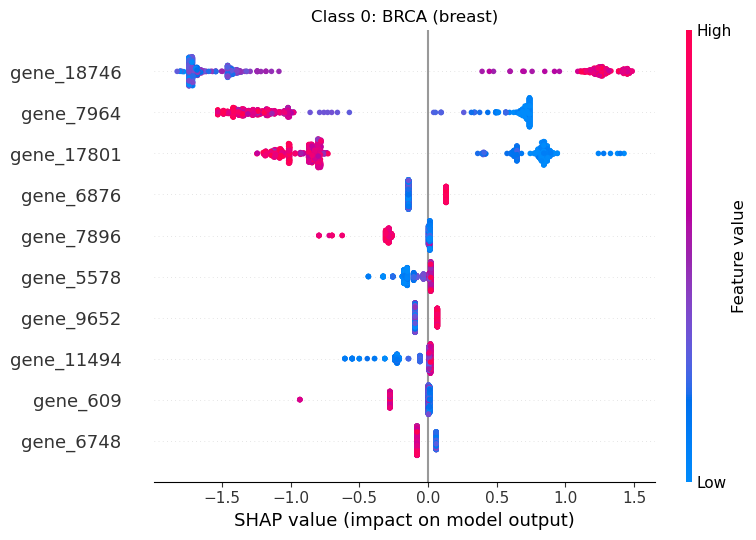

In [37]:
def get_summary_plot (class_num):
    message = f"Class {a[class_num]}"
    plt.title(message)
    return shap.summary_plot(shap_values[class_num], X, max_display=10)

get_summary_plot(0)

The swarm plot below gives us the most clear view of the values of gene_18746 and their distribution for each class.  The values of gene_18746 are generally higher than all of the other classes.  The tail, however, crosses the values in all of the other classes, helping us understand the overlap of positive and negative feature values for low SHAP values above. When the value of gene_18746 rises above approximately 11, the model should have no trouble predicting the sample's membership to the BRCA class.

In [38]:
data_and_labels = pd.merge(data, labels, on="Unnamed: 0")

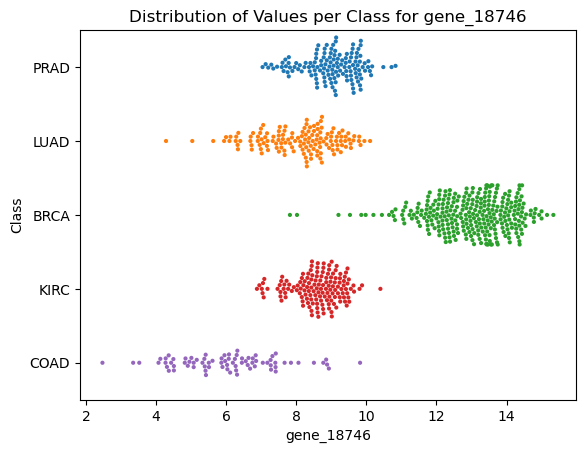

In [39]:
def get_swarm_plot (gene, size):
    message = f"Distribution of Values per Class for {gene}"
    plt.title(message)
    return sns.swarmplot(data=data_and_labels, x=gene, y="Class", size=size)

get_swarm_plot("gene_18746", 3);



### 3.8.2 Class 1: COAD (colon)
<a id='3.8.2_Class_1'></a>
Let's take a closer look at Class 1: COAD (color).  The plot of feature importance below shows there are again three main genes that impact the class membership.  For colon cancer they are gene_3523, gene_7238, and gene_12013.

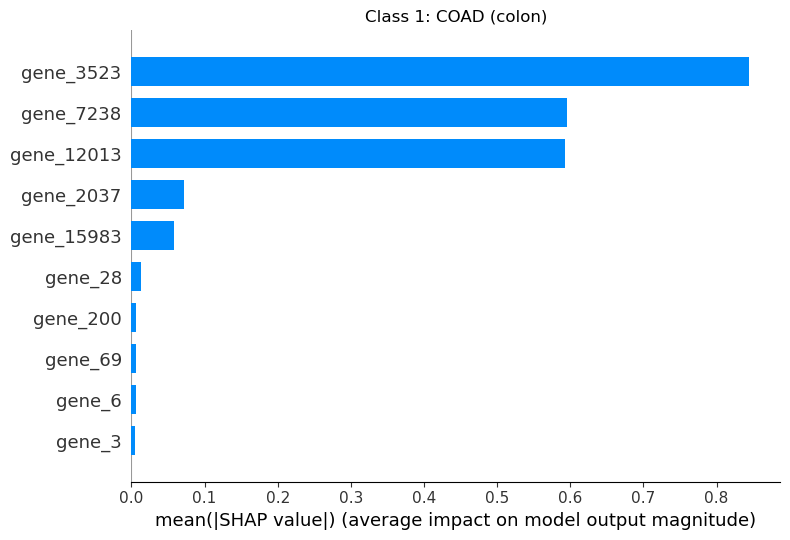

In [40]:
get_summary_bar_plot(1)

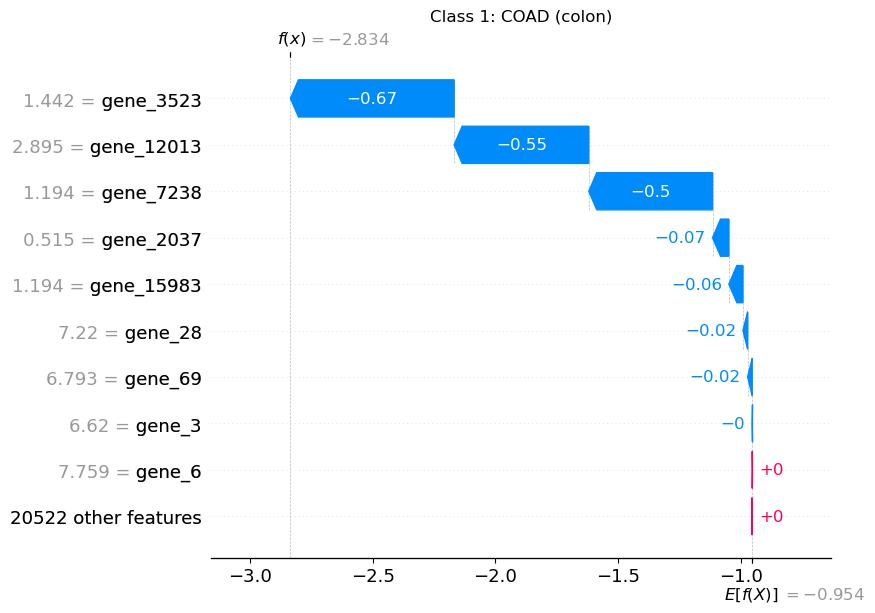

In [41]:
get_waterfall_plot(1,5)

The waterfall plot above and the force plot below, representing different predictions, both show lower SHAP values for the gene_3523 and gene_12013 contributing negatively to the prediction.

In [42]:
get_force_plot (1,12)

Contributing Features for Single Model Prediction in Class 1: COAD (colon)


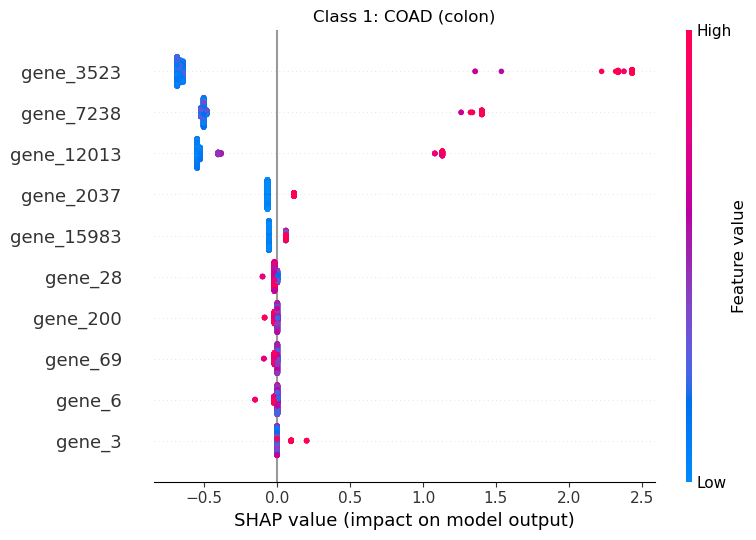

In [43]:
get_summary_plot(1)

The summary plot above and the swarm plot below both mirror what we saw with the feature of greatest importance in the previous class: higher SHAP values increase the likelihood of class membership, lower SHAP values decrease the liklihood of membership, and the distribution of values is noticable different from the values of the same gene in the other classes.

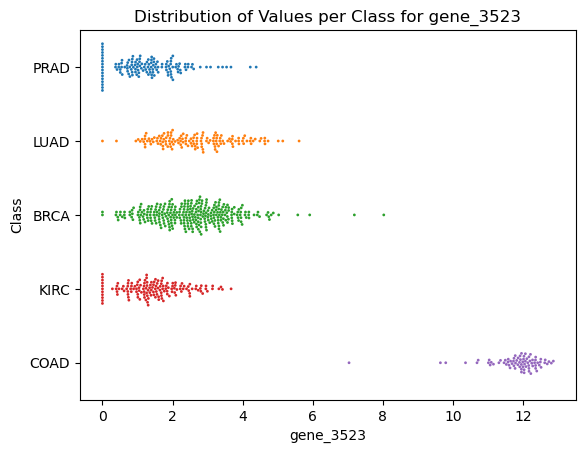

In [44]:
get_swarm_plot("gene_3523", 2);

### 3.8.3 Class 2: KIRC (kidney)
<a id='3.8.3_Class_2'></a>
The most influential features for kidney cancer are gene_12983, gene_6733, and gene_1858.  

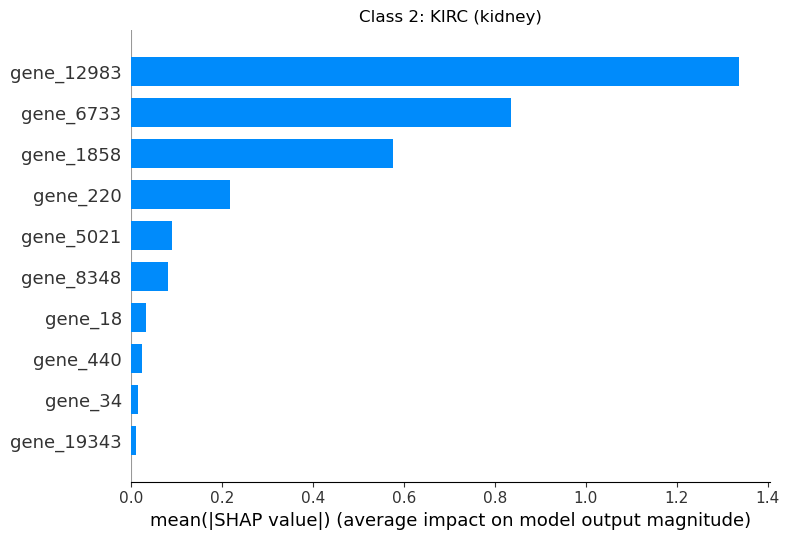

In [45]:
get_summary_bar_plot(2)

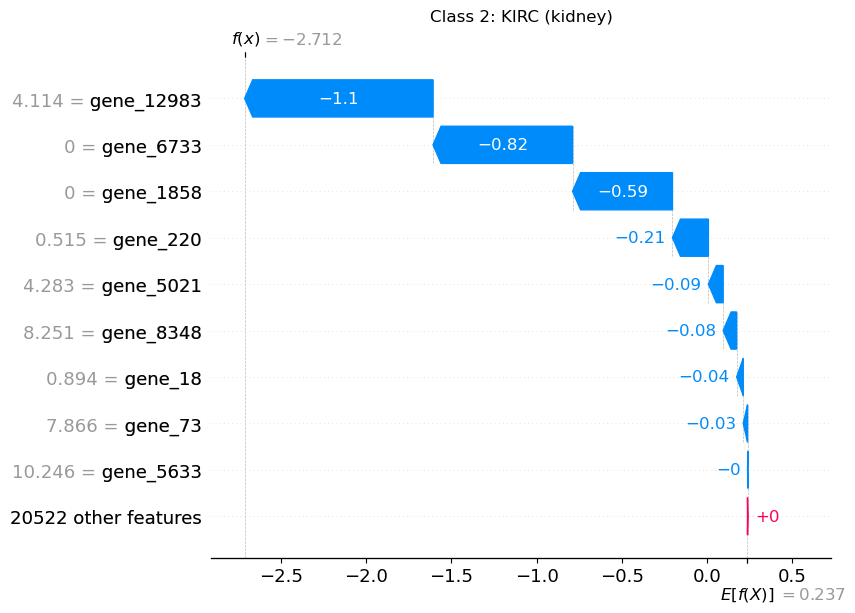

In [46]:
get_waterfall_plot(2,5)

The waterfall plot and forceplot for separate samples both show the three most important genes having a negative effect.

In [47]:
get_force_plot (2,10)

Contributing Features for Single Model Prediction in Class 2: KIRC (kidney)


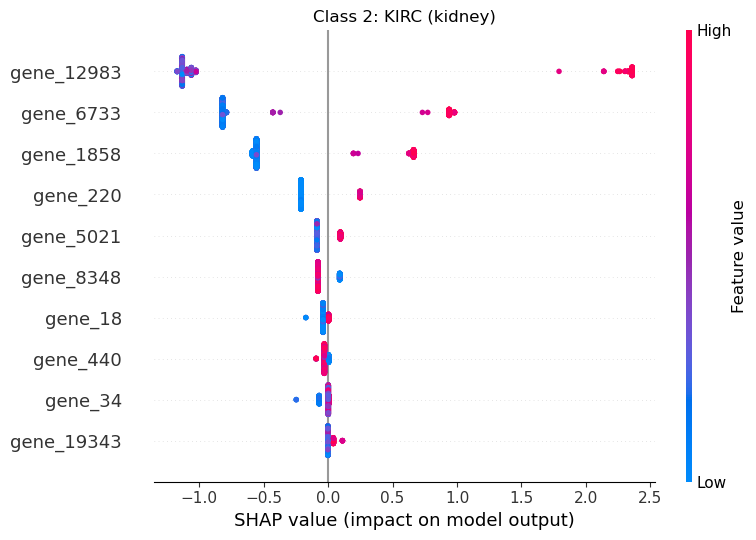

In [48]:
get_summary_plot(2)

The summary plot above looks similar to the summary plot for the breast cancer class for the top feature.  Higher SHAP values definitely result from high feature values, but low SHAP values have mixed feature values.  In the swarm plot below, we can see the overlap between the lowest values in the KIRC class and the highest values in the other classes.

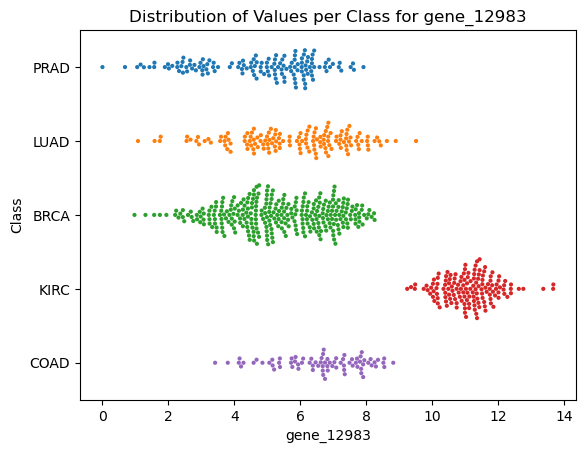

In [49]:
get_swarm_plot("gene_12983", 3);

### 3.8.4 Class 3:  LUAD (lung)
<a id='3.8.3_Class_3'></a>
The feature importance plot for the lung cancer class shows gene_15898, gene_15895, and gene_15899 as having the greatest impact.

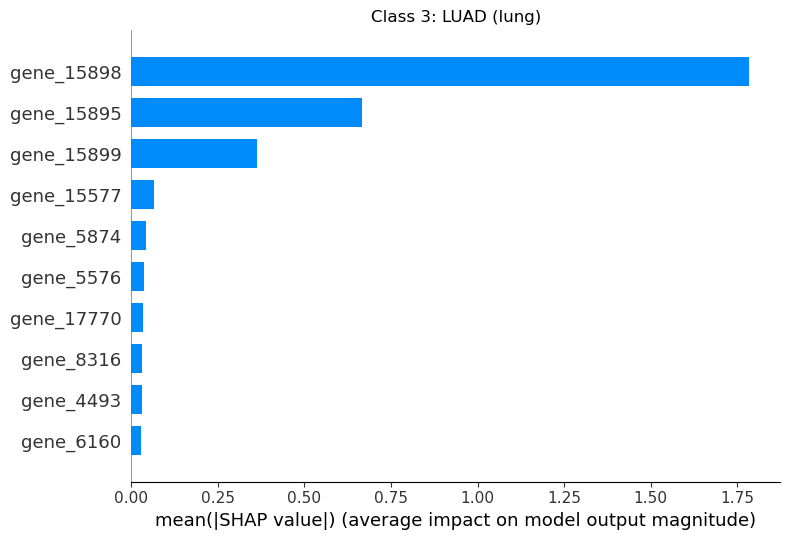

In [50]:
get_summary_bar_plot(3)

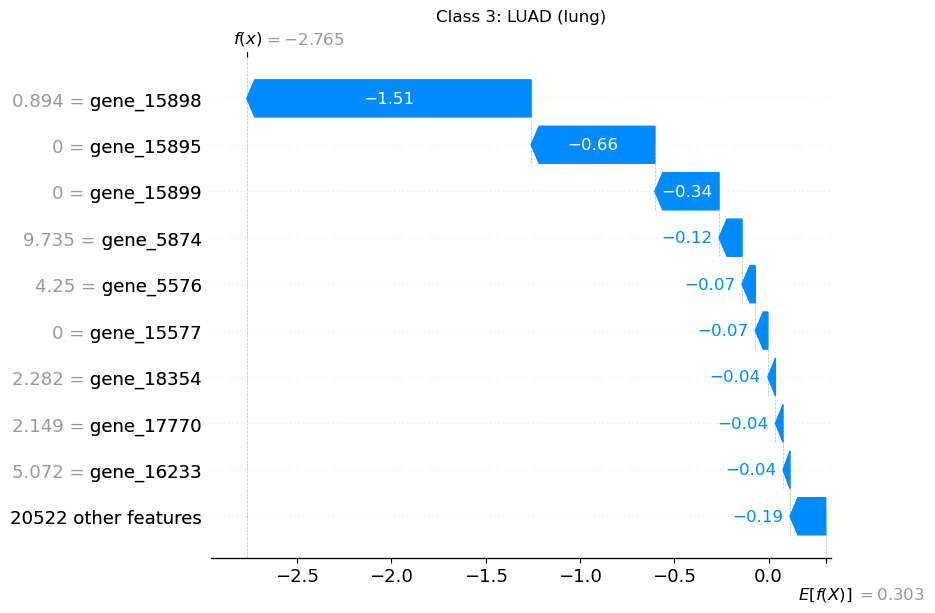

In [51]:
get_waterfall_plot(3,5)

Both of our single prediction plots show the top genes impacting the prediction in a negative direction.

In [52]:
get_force_plot (3,0)

Contributing Features for Single Model Prediction in Class 3: LUAD (lung)


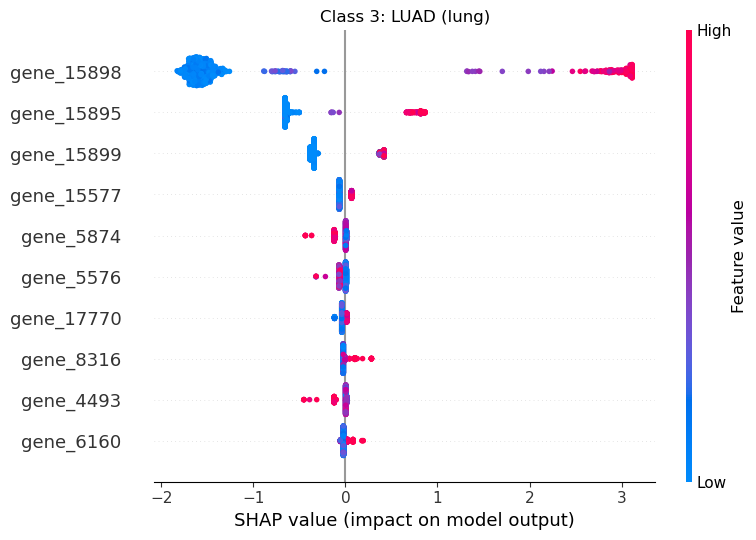

In [53]:
get_summary_plot(3)

The summary plot and the swarm plot for this class are a little more interesting.  We see some muddiness for positive SHAP values for gene_15898 and in the swarm plot, we see a wider distribution of values for the lung cancer class.

22.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
19.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
13.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


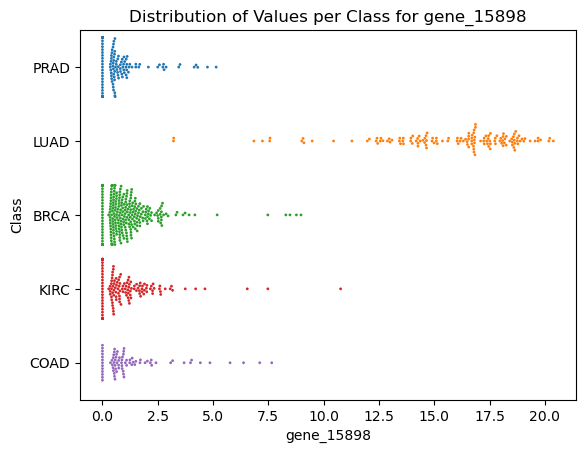

In [54]:
get_swarm_plot("gene_15898", 2);

### 3.8.5 Class 4:  PRAD (prostate)
<a id='3.8.3_Class_4'></a>
The prostate cancer class is unique in that we appear to only need one feature to predict class membership.

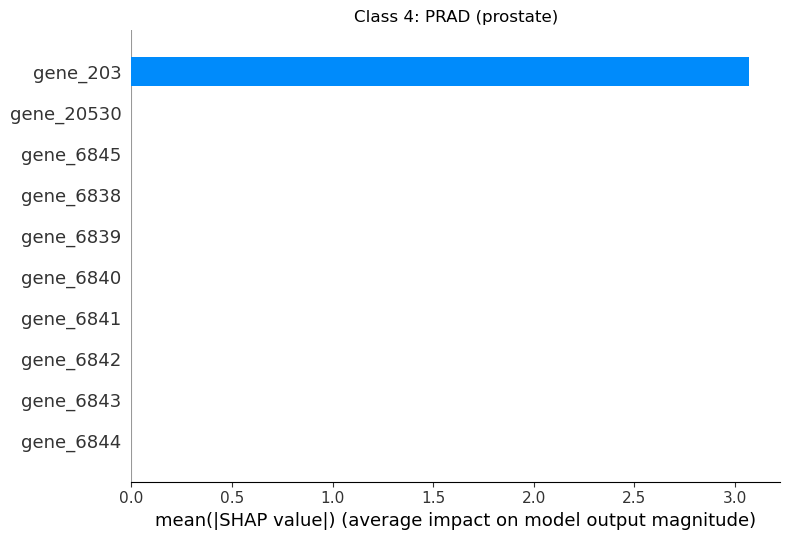

In [55]:
get_summary_bar_plot(4)

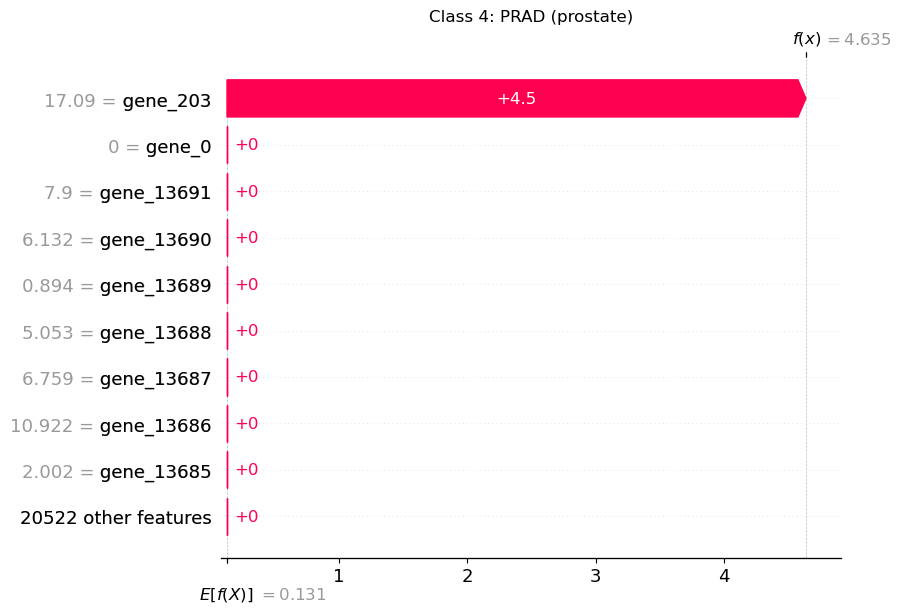

In [56]:
get_waterfall_plot(4,5)

In [57]:
get_force_plot (4,5)

Contributing Features for Single Model Prediction in Class 4: PRAD (prostate)


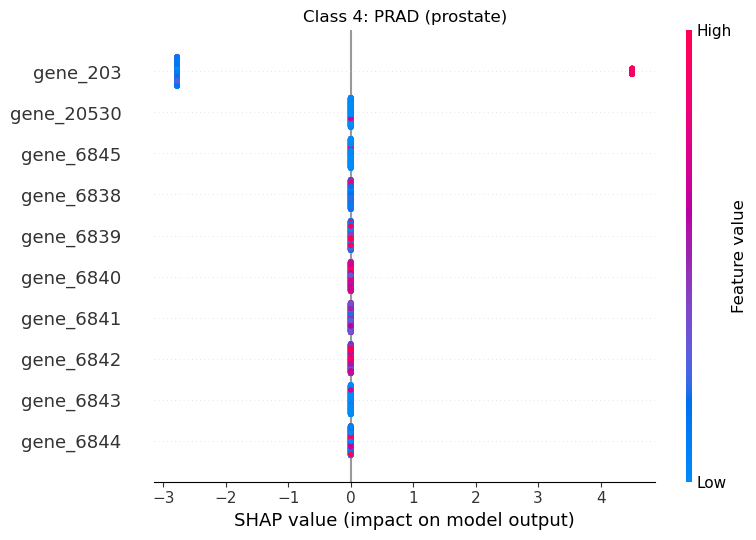

In [58]:
get_summary_plot(4)

All of the visuals show the same result: if you know the value of gene_203 you can confidently predict whether or not your sample is prostate cancer.

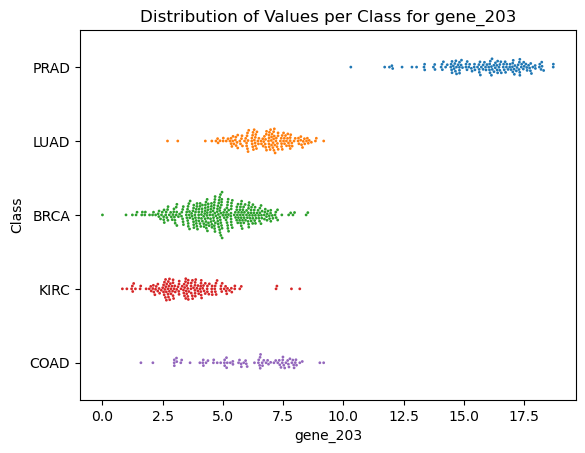

In [59]:
get_swarm_plot("gene_203", 2);

## 3.9 Summary
<a id='3.9_Summary'></a>

In this notebook, tried five new models and compared them to the baseline model.  All six models, which included both linear and non-liner models, performed very well with f1 macro scores ranging from 0.979 to 0.994.  KNeighborsClassifier, Logistic Regression, and Support Vector Classification all tied for the highest score.

For interpretation, I used the XGBoostClassifier model with SHAP and the resulting visualizations shed light on the reason for the high level of success of all the models.  There was a high level of separation between the distribution of values for the class to which the sample belongs as compared to all the other classes.  Lung cancer's primary contributing feature had a value distribution tail that crossed the other classes slightly more, and prostate cancer's primary (and only) contributing feature appears not to cross at all.

It is nice to see thatseveral different models can be used to successfully predict which cancer class the samples belong to in this dataset, and confidence building to see clearly the reasons why they are performing so well.  It gives one hope that the models will generalize well to other unseen samples in the future.